In [28]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sn
import torch
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
treino = torch.load("data/treino_particle.pt")
teste = torch.load("data/teste_particle.pt")

In [3]:
y_treino = treino[:,-1]
y_teste = teste[:,-1]
y_treino= y_treino.unsqueeze(1)
y_teste= y_teste.unsqueeze(1)


# Normalizando

In [4]:
sc = StandardScaler()
treino = torch.tensor(sc.fit_transform(treino[:,0:-1]))
teste = torch.tensor(sc.transform(teste[:,0:-1]))


In [29]:
joblib.dump(sc, 'model/standard_scaler.pkl')

['model/standard_scaler.pkl']

In [5]:
treino

tensor([[ 8.5258e+00, -2.1320e+00,  1.1592e+00,  ..., -1.0377e+00,
          3.3189e-01, -3.6683e-04],
        [ 2.9171e+00, -7.0611e-01,  3.9046e-01,  ..., -1.0078e+00,
          3.2751e-01, -8.8207e-02],
        [ 1.1627e+00, -3.1539e-01,  1.5021e-01,  ..., -7.8171e-01,
          3.1434e-01,  3.1148e-02],
        ...,
        [ 1.7953e-02,  6.1805e-02,  2.7225e-02,  ...,  1.7351e+00,
          9.3018e-01,  2.8682e-01],
        [ 2.4212e-02,  4.6964e-02,  2.7001e-02,  ..., -3.4784e-01,
          1.0628e+00, -8.6251e-01],
        [ 2.2772e-02,  4.5422e-02,  2.7330e-02,  ..., -7.3777e-01,
          1.0985e+00, -4.5579e-01]], dtype=torch.float64)

In [6]:
treino = torch.cat((treino, y_treino), dim=1)
teste = torch.cat((teste, y_teste), dim=1)


In [7]:
teste

tensor([[ 1.8510e+00,  3.5175e-01, -4.9835e-01,  ..., -6.3339e-01,
         -3.6683e-04,  0.0000e+00],
        [ 1.5011e+00,  5.5132e-01, -4.3908e-01,  ..., -6.5443e-01,
         -3.6683e-04,  0.0000e+00],
        [ 1.1895e+00,  4.3103e-01, -3.6678e-01,  ..., -6.8592e-01,
         -2.9363e-01,  0.0000e+00],
        ...,
        [-4.8097e-02, -3.2552e-02,  2.6035e-02,  ...,  9.6303e-01,
          2.2637e-01,  1.0000e+00],
        [-5.0006e-02, -2.6005e-02,  2.8216e-02,  ...,  1.0395e+00,
         -2.8387e-01,  1.0000e+00],
        [-2.2041e-02, -1.1962e-02,  1.3026e-02,  ...,  1.0576e+00,
         -5.3961e-01,  1.0000e+00]], dtype=torch.float64)

# DataLoader

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data_tensor, transform=None):
        self.data = data_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtendo as features e a label (target) da linha idx do tensor
        image = self.data[idx, 0:-1]
        label = self.data[idx, -1].long()

        # Aplicando transformações, se necessário
        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
dataset_treino = CustomDataset(treino)
dataset_teste = CustomDataset(teste)

In [27]:
dataset_treino.__getitem__(1)

(tensor([ 2.9171, -0.7061,  0.3905,  1.1941,  1.5284,  1.8736,  1.5322,  0.2422,
         -0.0956, -0.0864, -0.1327,  0.0454,  0.5499, -1.0078,  0.3275, -0.0882],
        dtype=torch.float64),
 tensor(0))

## Treino

In [12]:
batch_size = 128  
train_dataloader = DataLoader(dataset_treino, batch_size=batch_size, shuffle=True)

## Teste

In [13]:
batch_size = 128  
test_dataloader = DataLoader(dataset_teste, batch_size=batch_size, shuffle=True)

# Modelo

In [14]:
from torch import nn

In [15]:
class MLPClassification(nn.Module):
  def __init__(self,entrada):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(entrada,1000),
        nn.ReLU(),
        nn.Linear(1000,500),
        nn.ReLU(),
        nn.Linear(500,250),
        nn.ReLU(),
        nn.Linear(250,10),
        nn.ReLU(),
        nn.Linear(10,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.layers(x)

In [16]:
entrada = 16 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
model = MLPClassification(entrada).to(device)

In [18]:
model

MLPClassification(
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): ReLU()
    (6): Linear(in_features=250, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

# Função de Custo

In [19]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
#lossfunction = nn.BCEWithLogitsLoss()
lossfunction = nn.BCELoss()

# Função Treino e Teste

In [20]:
def train(modelo,dataloader,funcao_de_custo,otimizador):
  modelo.train() # praparado para ser treinado
  erro_acumulativo = 0.0
  for _, (data, target) in enumerate(dataloader):
    target, datas =  target.float().to(device), data.float().to(device)
    pred = modelo(datas)
    perda = funcao_de_custo(pred,target.unsqueeze(1).to(device))

    otimizador.zero_grad() # zero os gradientes acumulados
    perda.backward() #Calculo da gradiente
    otimizador.step() # anda para a direção de menos erro

    erro_acumulativo += perda.item()
  return erro_acumulativo/len(dataloader)


def test(modelo, dataloader, funcao_de_custo):
    modelo.eval()  
    total_acertos = 0
    total_exemplos = 0
    total_loss = 0.0

    with torch.no_grad():  
        for _, (data, target) in enumerate(dataloader):
            target, datas = target.float().to(device), data.float().to(device)

            pred = modelo(datas)
            loss = funcao_de_custo(pred, target.unsqueeze(1).to(device))

            # Arredonda as previsões para o valor mais próximo (0 ou 1)
            pred_labels = torch.round(pred)

            # Calcula o número de acertos
            total_acertos += (pred_labels == target.unsqueeze(1).to(device)).sum().item()
            total_exemplos += target.size(0)
            total_loss += loss.item()

    #accuracy = total_acertos / total_exemplos
    avg_loss = total_loss / len(dataloader)

    return  avg_loss

# Treinando o Modelo

In [21]:
vezes_treinando = 150
for t in range(vezes_treinando):
  train_erro = train(model,train_dataloader,lossfunction,optimizer)
  if t %100 ==0:
    print(f"Epoca {t}; erro : {train_erro}")
  test_erro = test(model,test_dataloader,lossfunction)
print(f"erro : {test_erro}")

Epoca 0; erro : 0.4173407023010254
Epoca 100; erro : 0.3924304985870785
erro : 0.4166505409276807


In [22]:
caminho_arquivo = 'model/1760_neuronios_adam_normalizado.pth'

# Salvar o modelo
torch.save(model.state_dict(), caminho_arquivo)

# Metricas

In [23]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(modelo, dataloader):
    modelo.eval()  # Define o modelo para o modo de avaliação
    all_labels = []
    all_probs = []

    with torch.no_grad():  # Desliga o cálculo de gradientes para economizar memória e acelerar o processo
        for _, (data, target) in enumerate(dataloader):
            target, imgs = target.float().to(device), data.float().to(device)

            pred_probs = torch.sigmoid(modelo(imgs)).cpu().numpy()  # Probabilidades previstas pelo modelo
            all_probs.extend(pred_probs)
            all_labels.extend(target.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



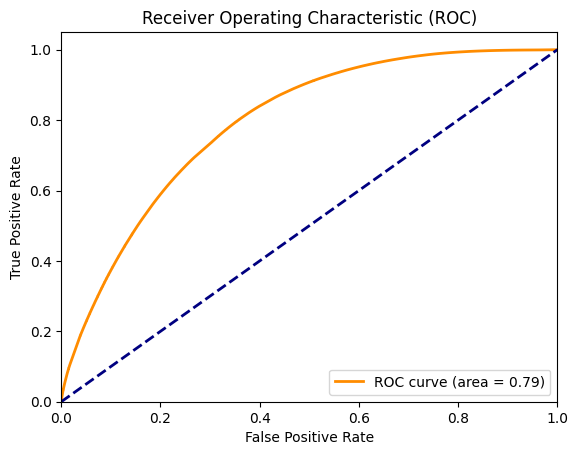

In [24]:
plot_roc_curve(model, test_dataloader)

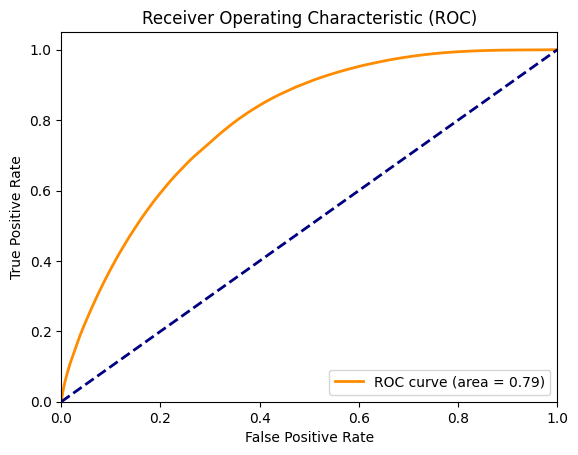

In [25]:
plot_roc_curve(model, train_dataloader)